# **EXPLORATORY DATA ANALYSIS**

In [73]:
import sys
print (sys.version)

3.10.1 (v3.10.1:2cd268a3a9, Dec  6 2021, 14:28:59) [Clang 13.0.0 (clang-1300.0.29.3)]


In [3]:
#pip install -r requirements.txt

In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [56]:
import pandas as pd
import re #regular expressions library for text manipulation
import string
import numpy as np
import unicodedata
import ast

from prettytable import PrettyTable

import csv
import os
import random

from glob import glob

#NLP libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.lang.en import English
import spacymoji
import emoji
import contractions

import itertools
from autocorrect import Speller

#for wordclouds
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#additional nlp models
#!python -m spacy download en_core_web_md

In [30]:
def clean_comments (filepath):
    """
    import comments from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `isSubmitter`,
    
    remove duplicates, etc
    
    """
    #import data
    df = pd.read_csv(filepath, low_memory = False)
    
    #remove deleted comments if any
    df = df[df.Body != '[deleted]']
    df = df[df.Body != '[removed]']
    df = df.dropna(subset=['Body'])
    
    #remove comments with missing id
    drop_index = df[df.isSubmitter.isnull()].index
    df.drop(drop_index, inplace = True)
    
    #remove duplicates if any
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #correct data types and column label
    df['Date_Created'] = pd.to_datetime(df['Date_Created'])
    df['year'] = df['Date_Created'].dt.year
    df['Score'] = df['Score'].astype('int') 
    df.rename(columns = {'Author_ID': "Author"}, inplace = True) 
    
    #rename 'Body' column to text
    df.rename(columns = {'Body': 'long_text',
                        'Date_Created': 'date_created'}, inplace = True)
    
    #remove unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'Author', 'Score',
       'Parent_ID', 'Submission_ID', 'Subreddit', 'isParent', 'isSubmitter'], inplace = True)
    
    #remove any extra whitespace in column labels
    df.columns = df.columns.str.strip()
    
    #include column to denote row is comment entry
    df['text_type'] = 'comment'
    
    #rearrange column order
    df = df[['text_type','ID','date_created', 'year', 'long_text']]
    
    
        
    return df



In [31]:
def clean_submissions(filepath):
    """
    import submissions/posts from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `Unnamed`,
    
    remove duplicates, etc
    
    """
    df = pd.read_csv(filepath, low_memory = False)
    
    #drop duplicate posts
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #create column for post title + post text
    df['long_text'] = df['Title']+ " " +df['Post Text'].fillna('')
    
    #adjust data types
    df['Date Created'] = pd.to_datetime(df['Date Created'])
    df['year'] = df['year'].astype('int')
    
    #rename columns
    df.rename(columns = {'Date Created': 'date_created'}, inplace = True)
    
    #remove unwanted columns
    df = df.drop(columns = ['Unnamed: 0', 'Title','Post Text', 'Score',
       'Total Comments', 'Post URL', 'SubReddit','Unnamed: 0.1'])
    
    #include column to denote row is comment entry
    df['text_type'] = 'submission'
    
    #reorder columns - 'ID', 'Post Text'
    df  = df[['text_type','ID', 'date_created','year', 'long_text']]
    
    return df
    

In [16]:
#access dataset files
folder_path = os.path.join("..", "Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../Data/corpus_v5.csv',
 '../Data/corpus_v4.csv',
 '../Data/filtered_corpus.csv',
 '../Data/corpus_v3.csv',
 '../Data/corpus_v2.csv',
 '../Data/full_posts.csv',
 '../Data/bert_train_data.csv',
 '../Data/training_data.csv',
 '../Data/vocabulary.csv',
 '../Data/emoji_subset.csv',
 '../Data/bert_train_data2.csv',
 '../Data/sampled_subset.csv',
 '../Data/training_corpus.csv',
 '../Data/comments.csv',
 '../Data/corpus.csv']

In [24]:
#import raw data and get num of rows
raw_comments = pd.read_csv('../Data/comments.csv')
raw_submissions = pd.read_csv('../Data/full_posts.csv')

/var/folders/b8/lw1d456n3zv1tb19_0tkz8_80000gn/T/ipykernel_7861/3475519086.py:2: DtypeWarning: Columns (0,4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_comments = pd.read_csv('../Data/comments.csv')


In [26]:
comments_filepath = '../Data/comments.csv'
submissions_filepath = '../Data/full_posts.csv'


data = pd.concat([clean_comments(comments_filepath), clean_submissions(submissions_filepath)], ignore_index = True)

data.head()

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅


<h2> Details of Data </h2>

In [49]:
#create table headings
data_summary = PrettyTable(['', 'raw_data', 'clean_data'])

#create row labels
data_summary.add_row(['posts',len (raw_submissions), len(data[data.text_type =='submission'])])
data_summary.add_row(['comments',len (raw_comments), len(data[data.text_type =='comment'])])
data_summary.add_row(['========','========','========'])
data_summary.add_row(['total', (len(raw_submissions)+ len(raw_comments)), 
                      (len(data[data.text_type =='submission'])+ len(data[data.text_type =='comment']))])

print (data_summary)

+----------+----------+------------+
|          | raw_data | clean_data |
+----------+----------+------------+
|  posts   |   4255   |    4255    |
| comments |  129521  |   124628   |
| ======== | ======== |  ========  |
|  total   |  133776  |   128883   |
+----------+----------+------------+


In [48]:
#table of entries per year
year_group = data.groupby(by='year')

entries_per_year = PrettyTable(['year', 'entries'])
for year, group in year_group:
    entries_per_year.add_row([year, len(group)])

print (entries_per_year)

+------+---------+
| year | entries |
+------+---------+
| 2012 |    11   |
| 2013 |    60   |
| 2014 |   143   |
| 2015 |   203   |
| 2016 |   786   |
| 2017 |   1127  |
| 2018 |   1676  |
| 2019 |   4217  |
| 2020 |  29760  |
| 2021 |  28034  |
| 2022 |  36342  |
| 2023 |  26524  |
+------+---------+


## **DATA DISTRIBUTION**

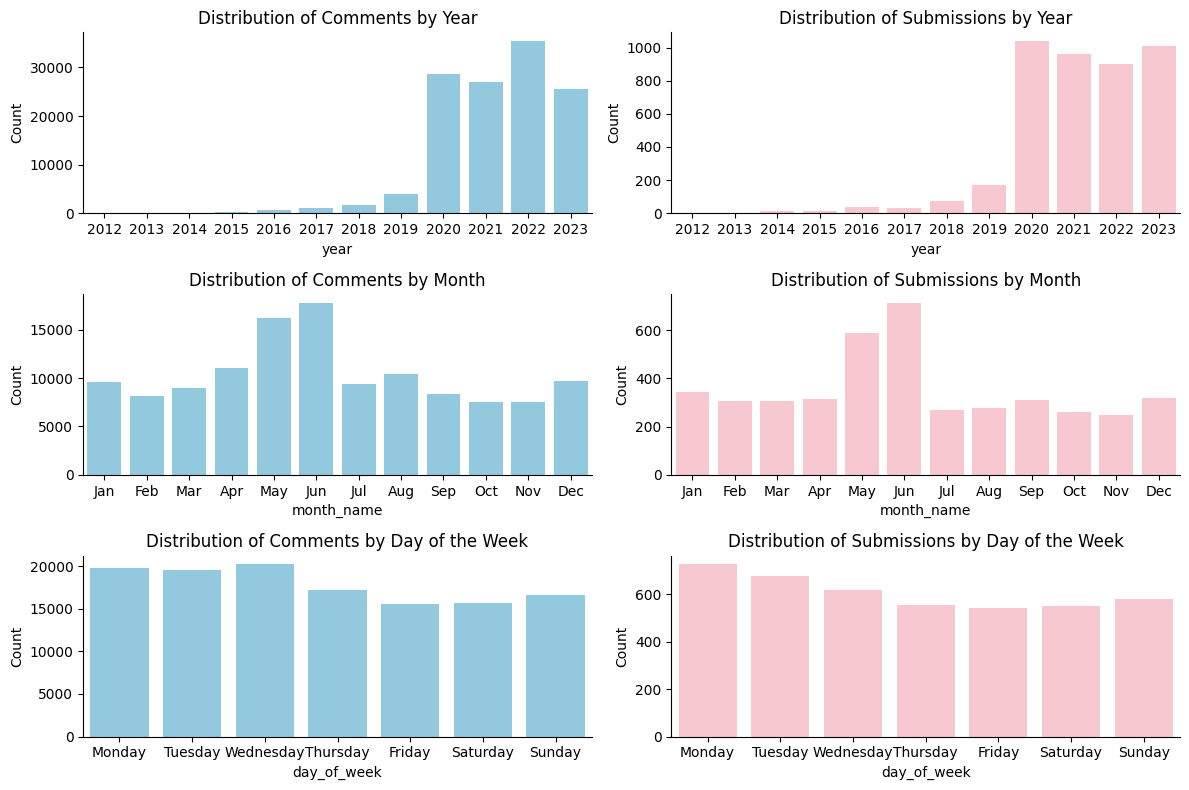

In [71]:
# showing temporal distribution of data

# Creating new columns for month and day of the week
data['month'] = data['date_created'].dt.month
data['day_of_week'] = data['date_created'].dt.day_name()
month_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
data['month_name'] = data['month'].replace(month_mapping)

# Filtering data for comments and submissions
comments_data = data[data['text_type'] == 'comment']
submissions_data = data[data['text_type'] == 'submission']

#function to plot distribution
def plot_distribution(data, title,color, ax):
    # plot the data 
    sns.countplot(data=data, x='year', color = color, ax=ax[0])
    sns.countplot(data=data, x='month_name', color =color, 
                  order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                      ax=ax[1])
    sns.countplot(data=data, x='day_of_week', 
                  order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                  color = color, ax=ax[2])
    #plot design
    for axis in ax:
        axis.set_ylabel('Count')
        axis.spines['top'].set_visible(False)  # Remove top border
        axis.spines['right'].set_visible(False)  # Remove right border
    ax[0].set_title(f'Distribution of {title} by Year')
    ax[1].set_title(f'Distribution of {title} by Month')
    ax[2].set_title(f'Distribution of {title} by Day of the Week')

# Plotting the distribution for comments and submissions with consistent colors
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

#set colors
com_color = "skyblue"
sub_color = 'pink'

#display the plots
plot_distribution(comments_data, "Comments", com_color, axes[:, 0])
plot_distribution(submissions_data, "Submissions", sub_color,  axes[:, 1])

plt.tight_layout()
plt.show()


### **Convert all Text to Lowercase**

In [74]:
data['clean_text'] = data['long_text'].apply(lambda text: text.lower())

data.sample(n=5)

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
7962,comment,fom1b80,2020-04-26 08:33:42,2020,If you swipe the image there's an English vers...,4,Sunday,Apr,if you swipe the image there's an english vers...
83505,comment,j5m49yt,2023-01-24 03:45:19,2023,Etisalat?,1,Tuesday,Jan,etisalat?
21246,comment,g1f40w5,2020-08-14 11:28:51,2020,It's been a long time since the Arab world did...,8,Friday,Aug,it's been a long time since the arab world did...
86595,comment,g1gukru,2020-08-14 22:15:09,2020,"Thanks, please give it a share!",8,Friday,Aug,"thanks, please give it a share!"
52421,comment,jc0v16j,2023-03-13 09:33:44,2023,What’s the etiquette when you’re doing 120 in ...,3,Monday,Mar,what’s the etiquette when you’re doing 120 in ...


In [75]:
data['clean_text'] = data['clean_text'].apply(lambda text: contractions.fix(text)) 

data.sample(n=5)

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
14945,comment,ir8iac8,2022-10-06 06:58:32,2022,The Gulf used to be more affordable. It is in ...,10,Thursday,Oct,the gulf used to be more affordable. it is in ...
16702,comment,i2qtrdq,2022-03-30 22:13:06,2022,"Well, you dont look like your name. Seeing a w...",3,Wednesday,Mar,"well, you do not look like your name. seeing a..."
98664,comment,gfy90bt,2020-12-15 23:18:37,2020,"Careful, they might track you down and deport ...",12,Tuesday,Dec,"careful, they might track you down and deport ..."
123474,comment,ghxv9jq,2021-01-03 15:53:51,2021,Well clearly I upset you. I'm sorry my comment...,1,Sunday,Jan,well clearly i upset you. i am sorry my commen...
41188,comment,jfsyfum,2023-04-11 12:28:59,2023,it was definitely the right thing to do! good ...,4,Tuesday,Apr,it was definitely the right thing to do! good ...


In [ ]:
#pd.reset_option('display.max_colwidth')

In [76]:
#index of rows with urls
html_index = data[data['long_text'].str.contains("https")].index
data.loc[html_index]

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,4,Monday,Apr,meditation and relaxation music https://youtu....
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,3,Friday,Mar,i am curious about this apollo fintech gsx coi...
93,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,3,Friday,Mar,https://www.instagram.com/p/ckhzbwph0c4/?igshi...
171,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...",3,Sunday,Mar,"with all due respect, do you expect a law enfo..."
290,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,3,Monday,Mar,here: dubai festival city\nhttps://maps.app.go...
...,...,...,...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,6,Monday,Jun,help‼️uni qualification equivalency letter for...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,6,Monday,Jun,psa: villas are at high risk of fire during th...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",6,Monday,Jun,"daily random discussion thread hello,\n\nthis ..."
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,6,Sunday,Jun,need help with applying for residency - confus...


In [77]:
#regex pattern for urls
url_pattern = r'https?://\S+'
#replace url with empty string
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(url_pattern, ' ', text, flags=re.MULTILINE))

data.loc[html_index]

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,4,Monday,Apr,meditation and relaxation music
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,3,Friday,Mar,i am curious about this apollo fintech gsx coi...
93,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,3,Friday,Mar,\n\nhere is a video explaining the same.
171,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...",3,Sunday,Mar,"with all due respect, do you expect a law enfo..."
290,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,3,Monday,Mar,here: dubai festival city\n \n\nthen follow th...
...,...,...,...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,6,Monday,Jun,help‼️uni qualification equivalency letter for...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,6,Monday,Jun,psa: villas are at high risk of fire during th...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",6,Monday,Jun,"daily random discussion thread hello,\n\nthis ..."
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,6,Sunday,Jun,need help with applying for residency - confus...


In [78]:
data['clean_text'] = data['clean_text'].apply(
                                            lambda text: unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8'))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
104275,comment,jiu6n21,2023-05-04 19:00:39,2023,"Eating pork is forbidden, using the same utens...",5,Thursday,May,"eating pork is forbidden, using the same utens..."
40562,comment,ioa0op5,2022-09-13 20:38:41,2022,Pick wasl properties. It is monthly payment,9,Tuesday,Sep,pick wasl properties. it is monthly payment
19333,comment,jkr4pnc,2023-05-19 14:15:24,2023,🤐,5,Friday,May,
53996,comment,jd6qqmq,2023-03-22 10:17:13,2023,I wouldnt be able to tell if this is fake one....,3,Wednesday,Mar,i would not be able to tell if this is fake on...
110298,comment,hp9ytki,2021-12-20 13:13:25,2021,Is foot tapping allowed?,12,Monday,Dec,is foot tapping allowed?


In [79]:
#index of some rows with punctuations
checker_list = ['ifquow','gzl2ec','147gsfl','vtelex',
 '12pqx6m','fuxrd2','2ui6wu','l4gz0u','14f4uyi','14f8d30']

rows_to_check = data[data['ID'].isin(checker_list)].index.tolist()

rows_to_check.extend([32003, 116022,18460,5786,30109])

rows_to_check.extend(html_index)

print(rows_to_check[:5])

[124628, 125097, 126727, 126869, 127216]


In [80]:
#regex pattern for punctuations
punctuation_pattern = r'[^\w\s]'

#remove punctuations using `re.sub() method
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(r'[^\w\s]', ' ', text))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,8,Monday,Aug,guys we made it yay
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",6,Tuesday,Jun,psa immigration to canada australia nz hell...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,6,Monday,Jun,how to reach people who are asking for money g...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,4,Monday,Apr,how do you plan to spend your eid holiday any...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",7,Thursday,Jul,hi everyone i am currently looking for jobs t...
...,...,...,...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,6,Monday,Jun,help uni qualification equivalency letter for...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,6,Monday,Jun,psa villas are at high risk of fire during th...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",6,Monday,Jun,daily random discussion thread hello \n\nthis ...
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,6,Sunday,Jun,need help with applying for residency confus...


In [81]:
#remove `\n` from text
data['clean_text'] = data['clean_text'].str.replace('\n', ' ')
#remove `\t` from text
data['clean_text'] = data['clean_text'].str.replace('\t', ' ')

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,8,Monday,Aug,guys we made it yay
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",6,Tuesday,Jun,psa immigration to canada australia nz hell...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,6,Monday,Jun,how to reach people who are asking for money g...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,4,Monday,Apr,how do you plan to spend your eid holiday any...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",7,Thursday,Jul,hi everyone i am currently looking for jobs t...
...,...,...,...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,6,Monday,Jun,help uni qualification equivalency letter for...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,6,Monday,Jun,psa villas are at high risk of fire during th...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",6,Monday,Jun,daily random discussion thread hello this is...
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,6,Sunday,Jun,need help with applying for residency confus...


In [82]:
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join (word for word in text.split() if word.isalpha()))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
11746,comment,g4kgvp4,2020-09-09 21:59:54,2020,"Yeah, I think it's worth it from a societal pe...",9,Wednesday,Sep,yeah i think it is worth it from a societal pe...
110252,comment,hpoi8xi,2021-12-23 17:30:13,2021,Already have an XSX for this gaming generation...,12,Thursday,Dec,already have an xsx for this gaming generation...
90245,comment,jig84rt,2023-05-01 20:45:20,2023,At least be happy that he didn't ask it for 5 ...,5,Monday,May,at least be happy that he did not ask it for d...
90367,comment,jigkupc,2023-05-01 22:08:21,2023,😂😂😂,5,Monday,May,
80010,comment,j222ws9,2022-12-29 06:21:39,2022,Do they know the right people or is it income ...,12,Thursday,Dec,do they know the right people or is it income ...


In [83]:
nlp = spacy.load('en_core_web_md')

In [84]:
#data['clean_text'] = data['clean_text'].apply(lambda text: [token.lemma_ for token in nlp(' '.join(text))])
#data['clean_text'] = data['clean_text'].apply(lambda text: [token.lemma_ for token in nlp(text)])
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join(token.lemma_ for token in nlp(text)))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,month,day_of_week,month_name,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,8,Monday,Aug,guy we make it yay
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",6,Tuesday,Jun,psa immigration to canada australia nz hello d...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,6,Monday,Jun,how to reach people who be ask for money groce...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,4,Monday,Apr,how do you plan to spend your eid holiday any ...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",7,Thursday,Jul,hi everyone I be currently look for job tempor...
...,...,...,...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,6,Monday,Jun,help uni qualification equivalency letter for ...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,6,Monday,Jun,psa villas be at high risk of fire during the ...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",6,Monday,Jun,daily random discussion thread hello this be t...
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,6,Sunday,Jun,need help with apply for residency confuse abo...


In [85]:
nlp = spacy.load('en_core_web_md')

data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word.text for word in nlp(text) if not word.is_stop]))

data.sample(n=10)

KeyboardInterrupt: 

In [ ]:
#check top words after removal of common stop words

#list of all words in the dataframe
#all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
#fdist = FreqDist(all_words)

#common_words_dict = {word: freq for word, freq in sorted(fdist.items(), key = lambda item: item[1], reverse = True) if freq >= 3000} #fdist.most_common(10)

#table of common words
#common_words_table = PrettyTable(['word', 'count'])
#for word, count in common_words.items():
#    common_words_table.add_row([word, count])

#print (common_words_table)

In [ ]:
#save custom stop words list to .txt file

#with open('custom_stop_words.txt', 'w') as file:
#    for word in custom_sw:
#        file.write(f'{word}\n')
#    print ('file saved')

In [ ]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#load custom_stop_words list
with open('custom_stop_words.txt', 'r') as file:
    custom_sw = [line.strip() for line in file]
print (f'There are {len(custom_sw)} in the custom stop words list')
print ('\n')
print (random.sample(custom_sw, 5))

In [ ]:
#remove custom words

data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word for word in text.split() if word not in custom_sw]))

data.sample(n=5)                                    

In [ ]:
#check top words after removal of common stop words

#list of all words in the dataframe
all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

#common_words = fdist.most_common(10)

#table of common words
common_words_table = PrettyTable(['word', 'count'])
for word, count in fdist.most_common(10):
    common_words_table.add_row([word, count])

print (common_words_table)

In [ ]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
data['clean_text'] = data['clean_text'].str.strip().str.replace('\s+', ' ', regex = True)

sample_rows = [5786,18460, 103391, 129297]

#redo word_count
#data['word_count'] = data['clean_text'].apply (lambda text: len(text.split()))

data.loc[sample_rows]#.sort_values(by='word_count', ascending = False)

In [ ]:
data['tokens'] = data['clean_text'].apply(lambda text: word_tokenize(text))

data.iloc[rows_to_check]

In [ ]:
data['word_count'] = data['tokens'].apply (lambda tokens_list: len(tokens_list))

data.sort_values(by='word_count', ascending = False)

In [ ]:
#select only rows with more than 1 word
corpus = data[data['word_count'] > 2]

corpus.shape

In [ ]:
#load list of sample_subset indices

#sampling done previously by randomly selecting entries from each year

with open('sample_subset_index.txt', 'r') as file:
    subset_index = [line.strip() for line in file]

subset_index[:5]

In [ ]:
#remove randomly sampled subset


subset_index = corpus[corpus['ID'].isin(subset_index)].index.to_list()

#remove sample subset from corpus

training_data = corpus.drop(subset_index, axis = 0)
training_data.sort_values(by='word_count', ascending = False)

training_data

In [ ]:
#save corpus 
filename = '../Data/training_data.csv'

def export_csv():
    '''
    export pre-processed data to CSV
    '''
    training_data.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)

export_csv()

print ('file saved')

In [ ]:
"""def find_emoji(text):
    try:
        emoticon_details = next(emoji.analyze(text, join_emoji=True))
        emoticon = emoticon_details.chars
        #translated_emoji = emoji.demojize(emoticon.chars)
    except StopIteration:
        emoticon = ''  # Handle the case when no emoji is found
    return  emoticon

data['emoticons'] = data['long_text'].apply (lambda text: find_emoji(text) )
data['translated_emojis'] = data['emoticons'].apply(lambda text: emoji.demojize(text))

emoji_index = [3709,33734,129114,100878]

data.loc[emoji_index]"""